In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, np_utils
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import os
import glob
import json

Using TensorFlow backend.


In [10]:
data_path = 'PATH TO DATASET'
raw_data = os.listdir(data_path)
print(len(raw_data))
print(raw_data[:5])

600
['happy_0.wav', 'happy_0_l.wav', 'happy_0_q.wav', 'happy_1.wav', 'happy_10.wav']


Populating the interactive namespace from numpy and matplotlib


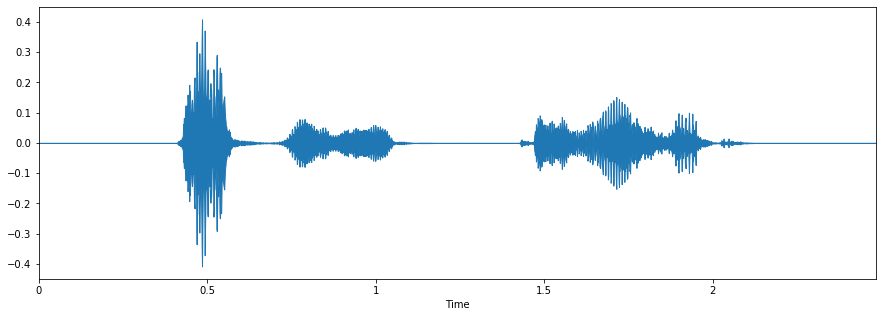

In [17]:
%pylab inline
plt.figure(figsize=(15, 5))
data, sampling_rate = librosa.load(os.path.join(data_path, 'happy_0.wav'), duration=2.5)
duration = librosa.get_duration(data, sr=sampling_rate)
librosa.display.waveplot(data, sr=sampling_rate)

In [4]:
feeling_list=[]
emotion = ['happy', 'sad']
for file in raw_data:
    emo = 'sad'
    if 'calm' in file:
        emo = 'calm'
    elif 'happy' in file:
        emo = 'happy'
        
    feeling_list.append(emo)

labels = pd.DataFrame(feeling_list)

In [11]:
df = pd.DataFrame(columns=['feature'])
i = 0
for index, y in enumerate(raw_data):
    data, sample_rate = librosa.load(os.path.join(data_path,y), res_type='kaiser_fast',duration=2.5,sr=22050*2)#,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs    
    df.loc[i] = [feature]
    i += 1   
    
feature_df = pd.DataFrame(df['feature'].values.tolist())
labeled_df = pd.concat([feature_df, labels], axis=1)
labeled_df = labeled_df.rename(index=str, columns={"0": "label"})
shuffled_df = shuffle(labeled_df)
shuffled_df=shuffled_df.fillna(0)

In [12]:
train_idxs = np.random.rand(len(shuffled_df)) < 0.8
train = shuffled_df[train_idxs]
test = shuffled_df[~train_idxs]
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

c:\users\samcw\desktop\projects\prosodic_assistant\env\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
model = Sequential()

model.add(Conv1D(256, 5, padding='same', input_shape=(215,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 215, 256)          1536      
_________________________________________________________________
activation_5 (Activation)    (None, 215, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 215, 128)          163968    
_________________________________________________________________
activation_6 (Activation)    (None, 215, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 215, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 26, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 26, 128)          

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [615]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=500, validation_data=(x_testcnn, y_test))

Train on 842 samples, validate on 208 samples
Epoch 1/500
842/842 [==============================] - 5s 5ms/step - loss: 0.7266 - accuracy: 0.5071 - val_loss: 0.6800 - val_accuracy: 0.5673
Epoch 2/500
842/842 [==============================] - 4s 5ms/step - loss: 0.6810 - accuracy: 0.5558 - val_loss: 0.6644 - val_accuracy: 0.6106
Epoch 3/500
842/842 [==============================] - 4s 5ms/step - loss: 0.6670 - accuracy: 0.5772 - val_loss: 0.6576 - val_accuracy: 0.6635
Epoch 4/500
842/842 [==============================] - 4s 5ms/step - loss: 0.6612 - accuracy: 0.5867 - val_loss: 0.6487 - val_accuracy: 0.6538
Epoch 5/500
842/842 [==============================] - 4s 5ms/step - loss: 0.6495 - accuracy: 0.6259 - val_loss: 0.6501 - val_accuracy: 0.6106
Epoch 6/500
842/842 [==============================] - 4s 5ms/step - loss: 0.6437 - accuracy: 0.6520 - val_loss: 0.6412 - val_accuracy: 0.6731
Epoch 7/500
842/842 [==============================] - 4s 5ms/step - loss: 0.6349 - accuracy: 0.

Epoch 114/500
842/842 [==============================] - 4s 5ms/step - loss: 0.3334 - accuracy: 0.8824 - val_loss: 0.4183 - val_accuracy: 0.8413
Epoch 115/500
842/842 [==============================] - 4s 5ms/step - loss: 0.3321 - accuracy: 0.8848 - val_loss: 0.4219 - val_accuracy: 0.7981
Epoch 116/500
842/842 [==============================] - 4s 5ms/step - loss: 0.3307 - accuracy: 0.8789 - val_loss: 0.4058 - val_accuracy: 0.8510
Epoch 117/500
842/842 [==============================] - 4s 5ms/step - loss: 0.3300 - accuracy: 0.8860 - val_loss: 0.4169 - val_accuracy: 0.8510
Epoch 118/500
842/842 [==============================] - 4s 5ms/step - loss: 0.3313 - accuracy: 0.8800 - val_loss: 0.4048 - val_accuracy: 0.8269
Epoch 119/500
842/842 [==============================] - 4s 5ms/step - loss: 0.3282 - accuracy: 0.8812 - val_loss: 0.4061 - val_accuracy: 0.8462
Epoch 120/500
842/842 [==============================] - 4s 5ms/step - loss: 0.3230 - accuracy: 0.8848 - val_loss: 0.3995 - val_ac

842/842 [==============================] - 4s 5ms/step - loss: 0.1233 - accuracy: 0.9762 - val_loss: 0.2699 - val_accuracy: 0.8942
Epoch 227/500
842/842 [==============================] - 4s 5ms/step - loss: 0.1218 - accuracy: 0.9786 - val_loss: 0.2789 - val_accuracy: 0.8894
Epoch 228/500
842/842 [==============================] - 4s 5ms/step - loss: 0.1203 - accuracy: 0.9786 - val_loss: 0.2543 - val_accuracy: 0.8942
Epoch 229/500
842/842 [==============================] - 4s 5ms/step - loss: 0.1176 - accuracy: 0.9739 - val_loss: 0.2614 - val_accuracy: 0.8990
Epoch 230/500
842/842 [==============================] - 4s 5ms/step - loss: 0.1145 - accuracy: 0.9846 - val_loss: 0.2927 - val_accuracy: 0.8942
Epoch 231/500
842/842 [==============================] - 4s 5ms/step - loss: 0.1208 - accuracy: 0.9810 - val_loss: 0.2405 - val_accuracy: 0.9087
Epoch 232/500
842/842 [==============================] - 4s 5ms/step - loss: 0.1137 - accuracy: 0.9857 - val_loss: 0.2551 - val_accuracy: 0.8894

842/842 [==============================] - 4s 5ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.1767 - val_accuracy: 0.9423
Epoch 339/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.1611 - val_accuracy: 0.9375
Epoch 340/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0223 - accuracy: 0.9976 - val_loss: 0.1500 - val_accuracy: 0.9519
Epoch 341/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.1724 - val_accuracy: 0.9519
Epoch 342/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.1500 - val_accuracy: 0.9519
Epoch 343/500
842/842 [==============================] - 5s 6ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.1527 - val_accuracy: 0.9567
Epoch 344/500
842/842 [==============================] - 5s 6ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.1526 - val_accuracy: 0.9519

842/842 [==============================] - 4s 5ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1302 - val_accuracy: 0.9663
Epoch 451/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1584 - val_accuracy: 0.9663
Epoch 452/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1370 - val_accuracy: 0.9663
Epoch 453/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1364 - val_accuracy: 0.9663
Epoch 454/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1497 - val_accuracy: 0.9615
Epoch 455/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1555 - val_accuracy: 0.9663
Epoch 456/500
842/842 [==============================] - 4s 5ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1392 - val_accuracy: 0.9663

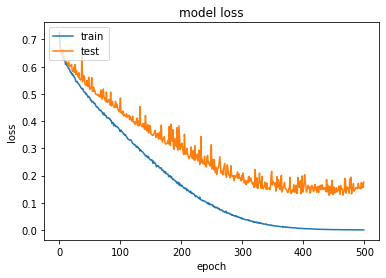

In [616]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [617]:
model_name = '2_cat.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\samcw\Desktop\projects\prosodic_assistant\dataset_creation\saved_models\2_cat.h5 


In [618]:
model_json = model.to_json()
with open("model_2_cat.json", "w") as json_file:
    json_file.write(model_json)